# Get data

In [65]:
import requests
import zipfile
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import torchvision

# computer deep learning libraries
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)


    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(requests.content)

    # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...") 
            zip_ref.extractall(image_path)



Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


# Become one with data

In [3]:
# check how many images and folders are there by walking through the data
for dirpath, dirnames, filenames in os.walk(image_path, topdown=True):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"


#### Visualise Image


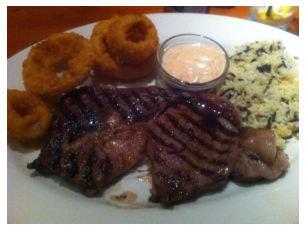

The shape of the image is (382, 512, 3)


In [5]:
torch.manual_seed(42)

# get all image paths
images_list = list(image_path.glob('*/*/*.jpg'))

# get a random path
random_image_path = random.choice(images_list)

# load the image
img = Image.open(random_image_path)

# convert the laoded image to numpyarray
np_array_image = np.asarray(img)

# plot the image 
plt.imshow(np_array_image)
plt.axis(False);
plt.show()

print(f"The shape of the image is {np_array_image.shape}")



# Transform Data

I've got folders of images but before I can use them with PyTorch, will need to convert them into tensors.

One of the ways to do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation.

To get experience with torchvision.transforms, a series of transform steps that I would like to perform are:
<ul>
<li>Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).</li>
<li>Flip the images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).</li>
<li>Turn  images from a PIL image to a PyTorch tensor using transforms.ToTensor().</li>
<li>I can compile all of these steps using torchvision.transforms.Compose().</li>
</ul>

In [6]:
data_transformations = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [7]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

# Data Loading 
Since this is a custom dataset, I need to load the data. 
<ul>There are 2 ways to do it
    <li>Load Images with Image Folder</li>
    <li>Load Images by writing a custom Class</li>
</ul>
Below I will do it using both options

### OPTION 1 : Load Images with Image Folder

In [8]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transformations, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transformations)

In [9]:
# get class names and indexes
class_names = train_data.classes
class_dict = train_data.class_to_idx

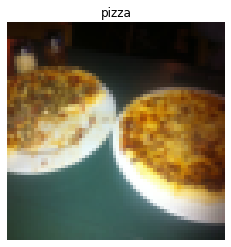

In [10]:
# Here the image is of dimension (C,H,W) to plot using matplot we need to change it to (H,W,C). 
# Cannot just queeze because squeeze can only remove all dimesnions of imput size 1. 
img, label = train_data[0]
img_permute = img.permute(1,2,0)
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False);
plt.show()

#### DataLoader

In [11]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=1, shuffle=False)

### OPTION 2 : Load Images with Custom Dataset

Steps:
<ul>
<li>traverse the target directory using scandir to get the class names</li>
<li>raise error if class names are not found</li>
<li>turn class names into a data dictionary</li>
<li>Create custom dataset to replicate ImageFolder. Steps are as follows</li>
    <ul>
    <li>Subclass torch.utils.data.Dataset.</li>
    <li>Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).</li>
    <li>Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).</li>
    <li>Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).</li>
    <li>Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).</li>
    <li>Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.</li>
    </ul>

</ul>

In [12]:
def find_classes(path:str):
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(path) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {path}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    return classes, class_to_idx

find_classes(path=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [13]:
from torch.utils.data import Dataset
# Write a custom dataset
class FoodImageDatasetCustom(Dataset):
    def __init__(self, targ_dir:str, transform = None) -> None:
        self.paths = list(targ_dir.glob('*/*.jpg'))

        self.transform = transform

        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self)-> int:
        return len(self.paths)
    
    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
    


In [14]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [15]:
train_data_custom = FoodImageDatasetCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = FoodImageDatasetCustom(targ_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.FoodImageDatasetCustom at 0x11edea130>,
 <__main__.FoodImageDatasetCustom at 0x11ed4ad90>)

In [16]:
# let's check the data
len(train_data_custom), len(test_data_custom)

(225, 75)

In [17]:
### check to see Dataset.ImageFolder vs CustomDataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)


True
True
True


# Create a function to display random images

In [18]:
def display_random_images(dataset:torch.utils.data.dataset.Dataset, n=10, classes=None, display_shape=True, seed=None):
    if seed:
        random.seed(seed)

    if n>10:
        n=10
        display_shape = False

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(24, 10))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        adjusted_image = targ_image.permute(1,2,0)

        #plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(adjusted_image)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {adjusted_image.shape}"
        plt.title(title)






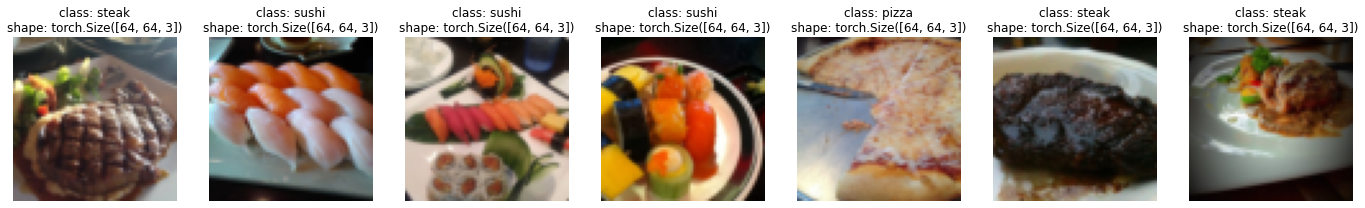

In [19]:
display_random_images(train_data, n =7, classes=class_names, seed=None)

In [20]:
# turn custom dataset into data loader
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=1, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, num_workers=0, shuffle=False)

In [21]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Other Transformations

The purpose of transformations is to alter the images. This can be done through cropping, rotating, turning into tensors etc.

There are many transformations that are available to us. These transfromations when applied usually perform better than our randomly picked transformations that we plan on applying to the image

I replace horizontal flip with one of the transformation available to us in Pytorch hoping to get better results

***Note*** <br/>
I am not performing transformations on the test data because we try to generalise using the training data and then we do the predictions on the test data. Only transformation that needs to take place on the test data will be to convert it into a tensor.

In [22]:
train_transforms_updated = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense it needs to be , ranges from 0 to 31
    transforms.ToTensor()
])

test_transforms_updated = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

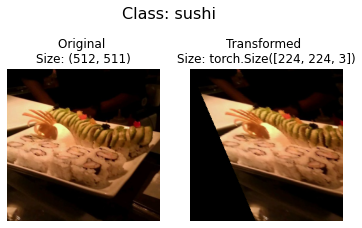

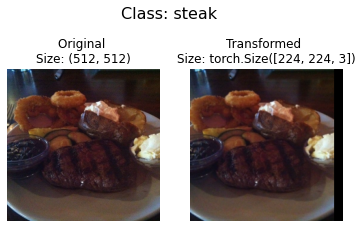

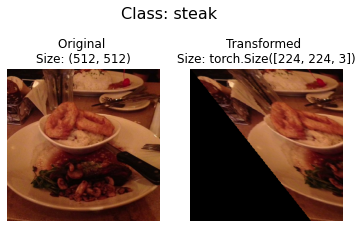

In [23]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms_updated,
    n=3,
    seed=None
)

# Model 0 - TinyVGG without Augumentation

In [24]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [25]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [26]:
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=32, num_workers=os.cpu_count(), shuffle=True)

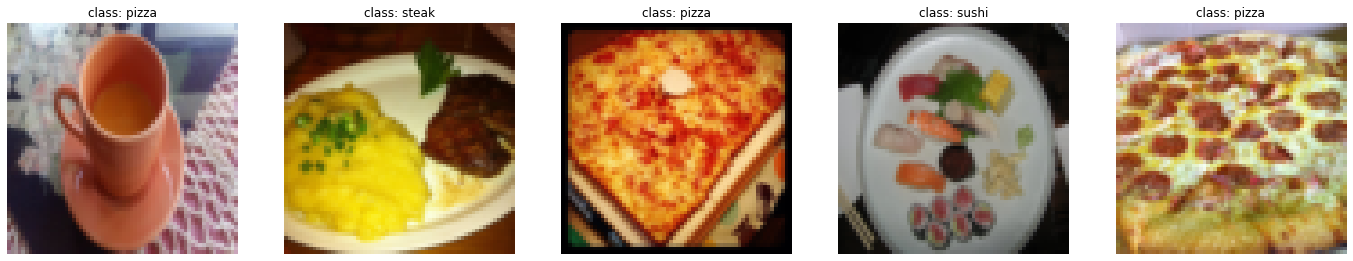

In [27]:
display_random_images(dataset=train_data_simple, n=5, display_shape=False, seed=None, classes=class_names)

In [28]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x):
        #print("before block 1 shape is ",x.shape)

        x = self.block1(x)
        #print("after block 1 shape is ",x.shape)

        x = self.block2(x)
        #print("after block 2 shape is ",x.shape)

        x = self.classifier(x)
        #print("after classifier shape is ",x.shape)

        return x


In [29]:
tinyVGG = TinyVGG(input_shape=3, hidden_units=100, output_shape= len(class_names))
loss_fn_simple = torch.nn.CrossEntropyLoss()
optim_simple = torch.optim.Adam(params=tinyVGG.parameters(), lr = 0.00001) 

In [30]:
# Get helper functions for plotting
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classe

helper_functions.py already exists, skipping download


In [31]:
# make functions for training testing and evaluation
def make_train(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optim:torch.optim.Optimizer, accuracy_fn = accuracy_fn):
    train_acc, train_loss = 0, 0
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        train_logits = model.forward(X)

        train_pred = torch.argmax(train_logits, dim=1)

        loss = loss_fn(train_logits, y)
        train_loss += loss.item()

        train_acc += accuracy_fn(y_true=y, y_pred=train_pred)

        optim.zero_grad()

        loss.backward()

        optim.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print("train loss is ",train_loss,"train Acc is ", train_acc)

    return train_loss, train_acc

def make_test(model:torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy_fn = accuracy_fn):
    test_loss, test_acc = 0,0

    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            test_logits = model.forward(X)

            test_pred = torch.argmax(input=test_logits, dim=1)

            loss = loss_fn(test_logits, y)
            test_loss += loss.item()
            
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print("test loss is ",test_loss,"test Acc is ", test_acc)

        return test_loss, test_acc

def model_eval(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy_fn):

    loss , acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            y_logits = model(X)

            y_pred = torch.argmax(y_logits, dim=1)

            loss += loss_fn(y_logits, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred)

        loss /= len(data_loader)
        acc /= len(data_loader)



In [33]:
from tqdm.auto import tqdm
epochs = 5

# Create empty results dictionary
results = {"train_loss": [],
"train_acc": [],
"test_loss": [],
"test_acc": []
}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = make_train(model=tinyVGG, data_loader=train_dataloader_simple, loss_fn=loss_fn_simple, optim=optim_simple, accuracy_fn=accuracy_fn)

    test_loss, test_acc = make_test(model=tinyVGG, data_loader=test_dataloader_simple, loss_fn=loss_fn_simple, accuracy_fn=accuracy_fn)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    

  0%|          | 0/5 [00:00<?, ?it/s]

train loss is  1.1007949262857437 train Acc is  30.46875
test loss is  1.1004927555720012 test Acc is  30.018939393939394
train loss is  1.100888192653656 train Acc is  30.46875
test loss is  1.097356915473938 test Acc is  33.996212121212125
train loss is  1.0948426127433777 train Acc is  42.578125
test loss is  1.0988715887069702 test Acc is  32.00757575757576
train loss is  1.0994235575199127 train Acc is  30.46875
test loss is  1.0980850060780842 test Acc is  33.996212121212125
train loss is  1.0983418226242065 train Acc is  30.46875
test loss is  1.0952543020248413 test Acc is  37.973484848484844


In [34]:
results

{'train_loss': [1.1007949262857437,
  1.100888192653656,
  1.0948426127433777,
  1.0994235575199127,
  1.0983418226242065],
 'train_acc': [30.46875, 30.46875, 42.578125, 30.46875, 30.46875],
 'test_loss': [1.1004927555720012,
  1.097356915473938,
  1.0988715887069702,
  1.0980850060780842,
  1.0952543020248413],
 'test_acc': [30.018939393939394,
  33.996212121212125,
  32.00757575757576,
  33.996212121212125,
  37.973484848484844]}

In [35]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

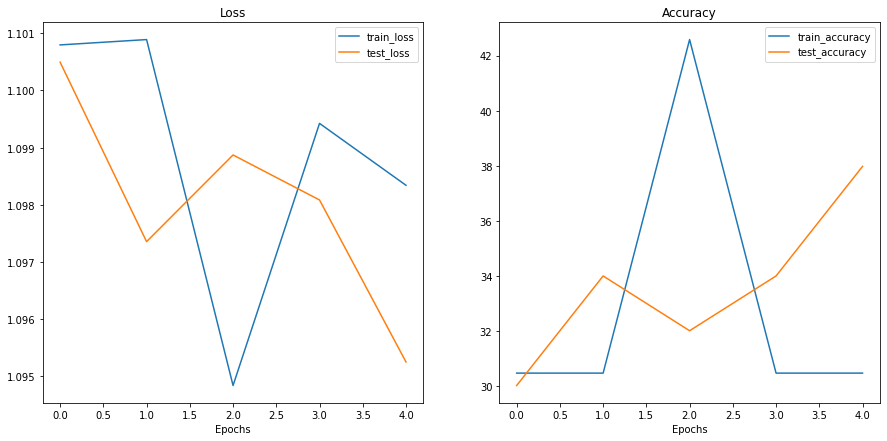

In [36]:
plot_loss_curves(results)

### The graphs show an erratic behaviour. This can mean multiple things
1. data too complex
2. Learning rate too high
3. Data is very noisy

These are only some reasons why this is happening. I will now try to redo the same model with data agumentations and see if there are any improvements.

# Model 1 - TinyVGG with Augumentations
I will now transform data using TrivialAugumentWide

In [43]:
transforms_trivial_augument = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [44]:
train_data_trivial_augument = datasets.ImageFolder(root=train_dir, transform= transforms_trivial_augument)
test_data_trivial_augument = datasets.ImageFolder(root=test_dir, transform= transforms_trivial_augument)

In [45]:
train_dataloader_trivial_augument = DataLoader(dataset=train_data_trivial_augument, num_workers=1, shuffle=True, batch_size=32)
test_dataloader_trivial_augument = DataLoader(dataset=test_data_trivial_augument, num_workers=1, shuffle=False, batch_size=32)

In [55]:
loss_fn_trivial_augument = torch.nn.CrossEntropyLoss()
optim_trivial_augument = torch.optim.Adam(params=tinyVGG.parameters(), lr=0.01)

In [56]:
epochs = 5

# Create empty results dictionary
results_2 = {"train_loss": [],
"train_acc": [],
"test_loss": [],
"test_acc": []
}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = make_train(model=tinyVGG, data_loader=train_dataloader_trivial_augument, loss_fn=loss_fn_trivial_augument, optim=optim_trivial_augument, accuracy_fn=accuracy_fn)

    test_loss, test_acc = make_test(model=tinyVGG, data_loader=test_dataloader_trivial_augument, loss_fn=loss_fn_trivial_augument, accuracy_fn=accuracy_fn)

    results_2["train_loss"].append(train_loss)
    results_2["train_acc"].append(train_acc)
    results_2["test_loss"].append(test_loss)
    results_2["test_acc"].append(test_acc)


  0%|          | 0/5 [00:00<?, ?it/s]

train loss is  29.21996945142746 train Acc is  39.84375
test loss is  48.978846867879234 test Acc is  26.041666666666668
train loss is  4.993453860282898 train Acc is  42.96875
test loss is  1.1405425071716309 test Acc is  19.791666666666668
train loss is  1.1465273946523666 train Acc is  27.734375
test loss is  1.106598138809204 test Acc is  19.791666666666668
train loss is  1.098570466041565 train Acc is  29.6875
test loss is  1.113085389137268 test Acc is  19.791666666666668
train loss is  1.1053796708583832 train Acc is  23.828125
test loss is  1.1137995322545369 test Acc is  26.041666666666668


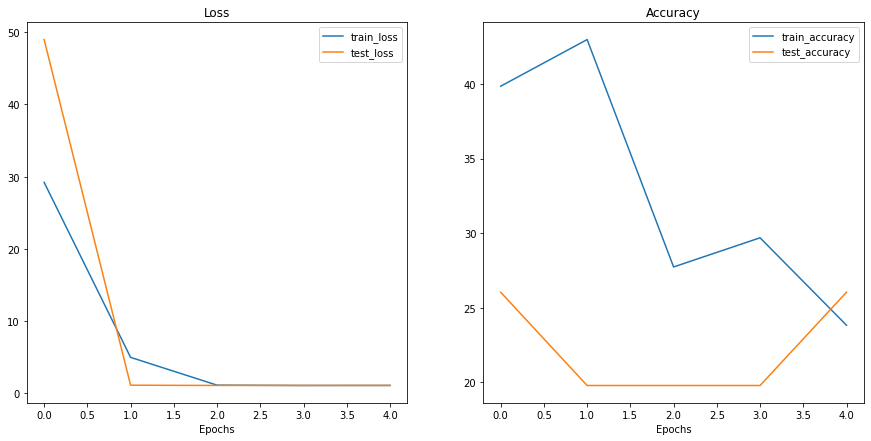

In [58]:
plot_loss_curves(results_2)

### I can observe that the model is still not doing so well. but the loss is reducing. 

#### <u>Method to prevent underfitting</u>

Method to prevent overfitting	What is it?
<Table>
<tr>
    <td>
    Get more data	
    </td>
    <td>
    Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
    </td>
</tr>
<tr>
    <td>
    Simplify your model
    </td>
    <td>
    If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
    </td>
</tr>
<tr>
    <td>
    Use data augmentation
    </td>
    <td>
	Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
    </td>
</tr>
<tr>
    <td>
    Use transfer learning
    </td>	
    <td>
    Transfer learning involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.
    </td>
</tr>
<tr>
    <td>
    Use dropout layers
    </td>
    <td>
    Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See torch.nn.Dropout() for more.
    </td>
</tr>
<tr>
    <td>
    Use learning rate decay
    </td>
    <td>
    The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to convergence, the smaller you'll want your weight updates to be.
    </td>
<tr>
    <td>
    Use early stopping
    </td>
    <td>
        Early stopping stops model training before it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior).
    </td>
</tr>
<table>

#### <u>Method to prevent underfitting</u>

Method to prevent Underfitting	What is it?
<Table>
<tr>
    <td>
    Add more layers/units to your model	
    </td>
    <td>
    If your model is underfitting, it may not have enough capability to learn the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers.
    </td>
</tr>
<tr>
    <td>
    Tweak the learning rate
    </td>
    <td>
    Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens.
    </td>
</tr>
<tr>
    <td>
    Use transfer learning
    </td>
    <td>
	Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem.
    </td>
</tr>
<tr>
    <td>
    Train for longer
    </td>	
    <td>
    Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance.
    </td>
</tr>
<tr>
    <td>
    Use less regularization
    </td>
    <td>
    Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better.
    </td>
</tr>
<table>

In [59]:
import pandas as pd
df_model_0_results = pd.DataFrame(results)
df_model_1_results = pd.DataFrame(results_2)

In [62]:
df_model_1_results

,train_loss,train_acc,test_loss,test_acc
0,29.219969,39.843750,48.978847,26.041667
1,4.993454,42.968750,1.140543,19.791667
2,1.146527,27.734375,1.106598,19.791667
3,1.098570,29.687500,1.113085,19.791667
4,1.105380,23.828125,1.113800,26.041667


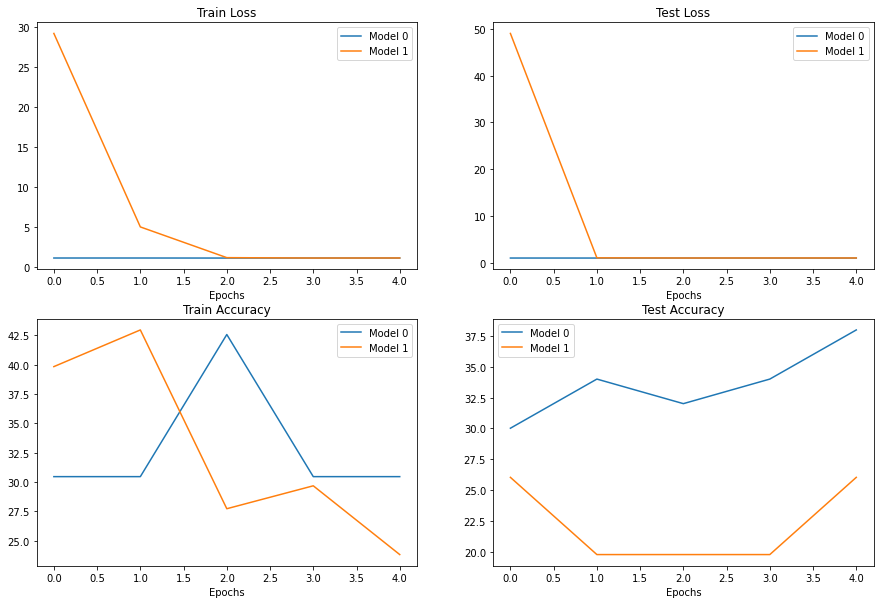

In [63]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(df_model_0_results))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, df_model_0_results["train_loss"], label="Model 0")
plt.plot(epochs, df_model_1_results["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, df_model_0_results["test_loss"], label="Model 0")
plt.plot(epochs, df_model_1_results["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, df_model_0_results["train_acc"], label="Model 0")
plt.plot(epochs, df_model_1_results["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, df_model_0_results["test_acc"], label="Model 0")
plt.plot(epochs, df_model_1_results["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

#### Both models are random guessing. I will first try to make a prediction and later see how we can improve the predictions

In [64]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [76]:
# load the data in the same format that the model was trained on and that is tensor form, shape (64,64)
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print("The custom image is of shape ", custom_image_uint8.shape)
print("The custom image is of type ", type(custom_image_uint8))
custom_image_float32 = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)



The custom image is of shape  torch.Size([3, 4032, 3024])
The custom image is of type  <class 'torch.Tensor'>


In [83]:
# if I am getting mat 1 and mat 2 cannot be multiplied then scale the values of the custom image and also use transforms to resize image
custom_image_float32 = custom_image_float32/255
print("The shape of custom image before transform is ", custom_image_float32.shape)
custom_image_transforms = transforms.Compose([transforms.Resize((64,64))])

# pass custom image through transformation 
custom_image_transformed = custom_image_transforms(custom_image_float32)
print("The shape of custom image after transform is ", custom_image_transformed.shape)

tinyVGG.eval()
with torch.inference_mode():
    prediction = tinyVGG.forward(custom_image_transformed.unsqueeze(0))


The shape of custom image before transform is  torch.Size([3, 4032, 3024])
The shape of custom image after transform is  torch.Size([3, 64, 64])


#### **To make predictions**
1. ensure the image is of same data type that model is trained on
2. ensure the image is of same input size that the model is trained on
3. ensure that the batch size is also appropriate



In [86]:
prediction

tensor([[ 0.0452,  0.0183, -0.0420]])

In [89]:
pred_label = torch.argmax(prediction,dim=1)


In [90]:
pred_label

tensor([0])

In [91]:
class_names[pred_label]

'pizza'

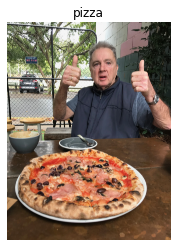

In [97]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.title(class_names[pred_label])
plt.axis(False);

Even with random guessing the model is getting the right output, FUNNY! However, I would like to finetune the model to improve it's performance